# 大数据管理作业05_LDA

郭英明 2183211376

In [7]:
import requests
from bs4 import BeautifulSoup
import jieba
import jieba.analyse
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import KMeans
from time import time
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from nltk.corpus import stopwords

## 导入并处理数据

In [8]:
all_data = fetch_20newsgroups(subset='all')
#删除所有标点符号、数字和特殊字符
data = all_data.data[:100]
news_df = pd.DataFrame({'document':data})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")
#删除较短的单词
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
#将文本变成小写，使得大小写失效
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())
#删除停止词
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
detokenized_doc = []

for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
news_df['clean_doc'] = detokenized_doc
#使用sklearn的TfidfVectorizer来创建一个包含1000个词项的文档-词项矩阵,单词文本矩阵为其转置。
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',
max_features =1000, # keep top 1000 terms
max_df = 0.5,
smooth_idf = True)
X = vectorizer.fit_transform(news_df['clean_doc'])
X1 = X.T
print(X1.shape)
print(X1)

(1000, 100)
  (740, 0)	0.10979634496519015
  (327, 0)	0.09526659939572656
  (438, 0)	0.11726566124920951
  (328, 0)	0.09526659939572656
  (185, 0)	0.1040026931491407
  (960, 0)	0.10979634496519015
  (764, 0)	0.2080053862982814
  (76, 0)	0.07726987308304926
  (786, 0)	0.09926893493653222
  (987, 0)	0.1040026931491407
  (345, 0)	0.14760578467967114
  (9, 0)	0.0860059668364634
  (228, 0)	0.23453132249841901
  (649, 0)	0.10979634496519015
  (462, 0)	0.08353135355250711
  (168, 0)	0.11726566124920951
  (654, 0)	0.09179961865251286
  (859, 0)	0.08874152490787428
  (394, 0)	0.04638376479627026
  (648, 0)	0.04474340120090837
  (578, 0)	0.04638376479627026
  (531, 0)	0.10979634496519015
  (116, 0)	0.10979634496519015
  (647, 0)	0.09179961865251286
  (299, 0)	0.23453132249841901
  :	:
  (215, 99)	0.33325853297107516
  (401, 99)	0.4443447106281002
  (177, 99)	0.4443447106281002
  (700, 99)	0.09544223455100186
  (513, 99)	0.3058051727297587
  (604, 99)	0.08629111447056302
  (585, 99)	0.09040600975

## LDA模型

### 从Scikit-learn库中导入新闻文本数据集(fetch_20newsgroups)，利用Scikit-learn库中的LDA模型进行话题分析，并绘制出各个主题下的高频词（如下图所示）。

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                learning_offset=50.,
                                random_state=0)
LDA_topic = lda.fit_transform(X)

In [20]:
lda.components_.shape

(10, 1000)

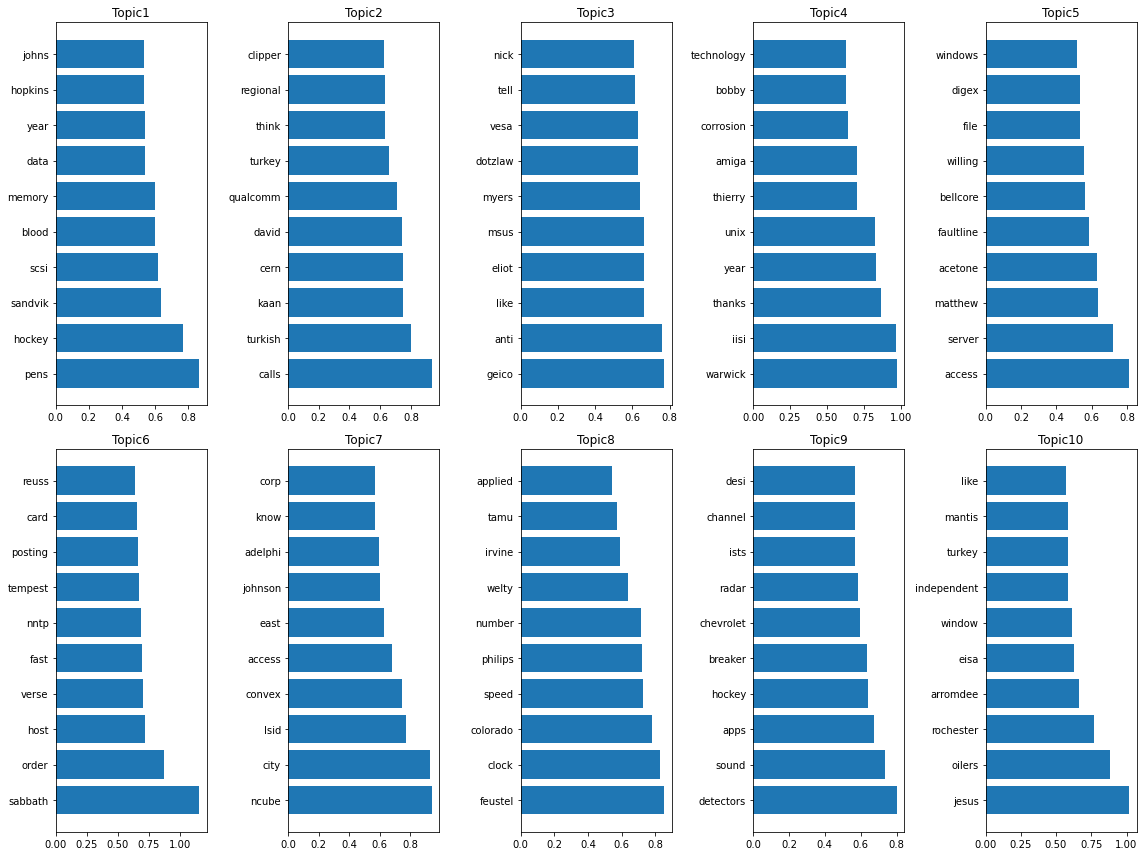

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 12))   
#打印出10个话题中前2个最重要的单词
terms = vectorizer.get_feature_names()
for i, comp in enumerate(lda.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
#     print("Topic "+str(i+1)+": ")
#     print(sorted_terms)
    x = []
    y = []
    for t in sorted_terms:
        x.append(t[0])
        y.append(t[1])
    ax = fig.add_subplot(2, 5, i + 1)
    plt.barh(x,y)
    plt.tight_layout()
    plt.title('Topic' +str(i+1))
    
plt.show()

### 从交大新闻网主页新闻栏目(http://news.xjtu.edu.cn/zyxw.htm)下载最新的100条新闻报道，利用Scikit-learn库中的LDA模型进行话题分析，并绘制出各个主题下的高频词，以及各个主题的词云（如下图所示）。

In [42]:
# 获取交大新闻网主页新闻的链接列表
news_url_list = []

nav_page = 1654
while len(news_url_list)<100:
    nav_url = "http://news.xjtu.edu.cn/zyxw/"
    nav_url = nav_url + str(nav_page) + ".htm"
    r = requests.get(nav_url)
    if r.status_code != 200:
        raise Exception()
    r.encoding='utf-8'

    soup = BeautifulSoup(r.text, "html.parser")
    for node in soup.find_all("a"):
        if node.has_attr('href') and not node.attrs['href'].find(u'../info/')==-1:
            news_url_list.append(node.attrs['href'])
            # print(node.attrs['href'])
    news_url_list = list(set(news_url_list))
    nav_page = nav_page - 1

print(news_url_list[0])

../info/1219/131682.htm


In [43]:
# 获取新闻内容
news_list = []
for news_url in news_url_list:
    news_url = news_url.replace('../', 'http://news.xjtu.edu.cn/')
    # print(news_url)
    
    r = requests.get(news_url)
    if r.status_code != 200:
        raise Exception()
    r.encoding='utf-8'

    soup = BeautifulSoup(r.text, "html.parser")
    text = str()
    for node in soup.find_all("p"):
        if node.get_text().find(u'上一条')==-1 and node.get_text().find(u'下一条')==-1 and node.get_text().find(u'关闭')==-1 and node.get_text().find(u'版权所有')==-1 and node.get_text().find(u'来源链接')==-1 and len(node.get_text().strip(' '))>0:
            text = text + node.get_text().strip(' ')
    news_list.append(text) 
    # print(text)

print(news_list[0])

第六届省政府法律顾问组聘任仪式4月9日举行。省长赵一德颁发聘书并讲话，省政府副秘书长唐少鹏主持。我校法学院院长单文华教授、副院长李万强教授等15位法律专家和资深律师被聘任为第六届省政府法律顾问。单文华教授作为受聘法律顾问代表发言。在听取第五届法律顾问组工作情况汇报和部分新聘任顾问发言后，赵一德指出，聘任法律顾问，是省政府贯彻落实习近平法治思想和全面依法治国方略、推进更高水平法治陕西建设工作的一项重要内容。担任省政府法律顾问使命光荣、责任重大，希望大家自觉做习近平法治思想的忠实实践者，学深悟透精神实质、把握核心要义、明确工作要求，切实用以指导法律实践、履行岗位职责。自觉做法治政府建设的坚定守护者，围绕省政府工作部署、规范性文件制定、行政执法等工作，及时提供专业权威的法律意见，从源头上守牢法律底线。自觉做服务改革发展大局的有力示范者，围绕把握新发展阶段、贯彻新发展理念、构建新发展格局，把法律服务做精做深做实，更好服务重大改革和重点工作，更好服务人民群众。自觉做更高水平法治陕西建设的积极倡导者，带头尊法守法普法，努力成为践行法治的榜样，促进形成良好法治环境。省政府将进一步健全政府系统法律顾问体系，加强沟通联系，努力为法律顾问履职尽责创造良好环境，共同推动我省法治政府建设迈上新的台阶。省政府秘书长方玮峰宣读了聘任通知，省直有关部门负责同志参加活动。相关报道：陕西电视台：http://www.snrtv.com/snr_sxxwlb/a/2021/04/10/19611710.html陕西日报：http://esb.sxdaily.com.cn/pc/content/202104/10/content_752994.html



In [45]:
# 导入停用词
stopwords = [line.strip() for line in open('D:\\桌面\\中文停用词库.txt',encoding='UTF-8').readlines()]
# print(stopwords)

In [46]:
# 使用jieba分词并去除停用词
seg_news_list = []
for news in news_list:
    seg_news = list(jieba.cut(news))
    # print('/'.join(seg_news))
    for word in seg_news:
        if word in stopwords:
            seg_news.remove(word)
    seg_news_list.append(' '.join(seg_news))
print(seg_news_list[0])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\gym\AppData\Local\Temp\jieba.cache
Loading model cost 0.865 seconds.
Prefix dict has been built successfully.


第六届 省政府 法律 顾问组 聘任 仪式 月 日 省长 赵一德 颁发 聘书 讲话 省政府 副 秘书长 唐少鹏 主持 我校 法学院 院长 文华 教授 副 院长 李万强 教授 15 位 法律 专家 资深 律师 聘任 第六届 省政府 法律顾问 单 文华 教授 受聘 法律顾问 代表 发言 在 听取 第五届 法律 顾问组 工作 情况汇报 部分 新 聘任 顾问 发言 赵一德 指出 聘任 法律顾问 是 省政府 贯彻落实 习近平 法治 思想 全面 依法治国 方略 推进 高水平 法治 陕西 建设 工作 一项 内容 担任 省政府 法律顾问 使命 光荣 责任重大 希望 自觉 做 习近平 法治 思想 忠实 实践者 学深悟 透 精神实质 把握 核心 要义 明确 工作 切实 用以 指导 法律 实践 履行 岗位职责 自觉 做 法治 政府 建设 坚定 守护者 围绕 省政府 工作 部署 规范性 文件 制定 行政 执法 工作 及时 提供 专业 权威 法律 意见 从 源头 上守牢 法律 底线 自觉 做 服务 改革 发展 大局 有力 示范者 围绕 把握 新 发展 阶段 贯彻 新 发展 理念 构建 新 发展 格局 把 法律 服务 做 精 做 深 做实 更好 服务 改革 重点 工作 更好 服务 群众 自觉 做 高水平 法治 陕西 建设 积极 倡导者 带头 尊法 守法 普法 努力 践行 法治 榜样 促进 良好 法治 环境 省政府 进一步 健全 政府 系统 法律顾问 体系 加强 沟通 ， 努力 法律顾问 履职 尽责 创造 良好环境 ， 共同 推动 我省 法治 政府 建设 迈上 新 台阶 省政府 秘书长 方玮峰 宣读 聘任 通知 ， 省直 部门 负责同志 参加 活动 。 相关 报道 陕西 电视台 http www snrtv com snr sxxwlb a 2021 04 10 19611710 html 陕西 日报 http esb sxdaily com cn pc content 202104 / 10 / content 752994 html 



In [49]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000, min_df=2)
X2 = vectorizer.fit_transform(seg_news_list)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 105, n_features: 4579


In [50]:
print(X2.shape)
print(X2)

(105, 4579)
  (0, 104)	0.09311181873129251
  (0, 127)	0.05937888471752201
  (0, 102)	0.043287529655046196
  (0, 138)	0.06264726442812207
  (0, 108)	0.06264726442812207
  (0, 2634)	0.052494749743923375
  (0, 110)	0.08290853455921775
  (0, 5)	0.06829110471634954
  (0, 103)	0.08290853455921775
  (0, 140)	0.05670842404984495
  (0, 111)	0.08468447011944938
  (0, 3236)	0.05670842404984495
  (0, 2326)	0.034678228609092
  (0, 3279)	0.028206711979897645
  (0, 2981)	0.02565296095432588
  (0, 1215)	0.027862061194056587
  (0, 4038)	0.046555909365646256
  (0, 4296)	0.04061706898736912
  (0, 4260)	0.05670842404984495
  (0, 1765)	0.06264726442812207
  (0, 1288)	0.05670842404984495
  (0, 4169)	0.06264726442812207
  (0, 2225)	0.06264726442812207
  (0, 2403)	0.026250879997248868
  (0, 862)	0.03767784880512435
  :	:
  (104, 4325)	0.0744805416587403
  (104, 1463)	0.04736021540072588
  (104, 413)	0.06272118539232904
  (104, 3392)	0.03837462398093505
  (104, 802)	0.06025629237805616
  (104, 4047)	0.05330526

In [58]:
lda2 = LatentDirichletAllocation(n_components=10,
                                learning_offset=50.,
                                random_state=0)
LDA2_topic = lda2.fit_transform(X2)

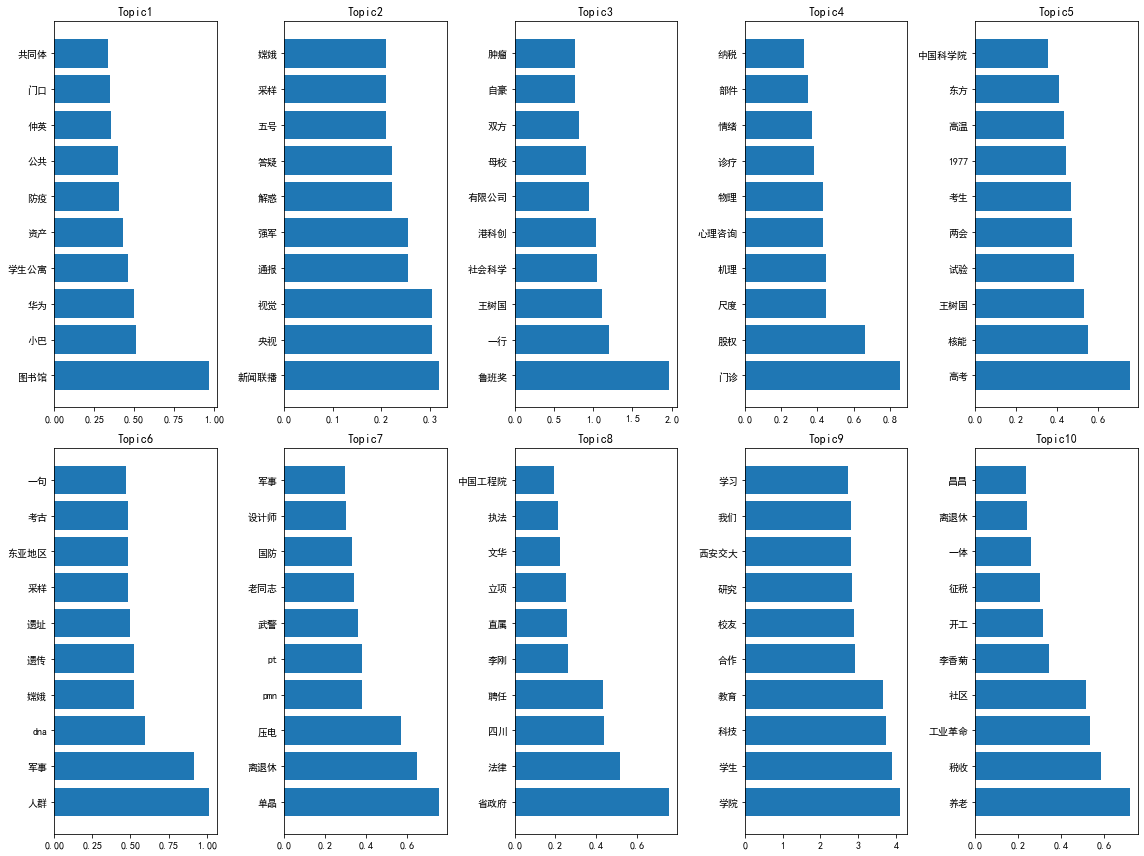

In [68]:
fig = plt.figure(figsize=(16, 12)) 
terms = vectorizer.get_feature_names()
for i, comp in enumerate(lda2.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
#     print("Topic "+str(i+1)+": ")
#     print(sorted_terms)
    x = []
    y = []
    for t in sorted_terms:
        x.append(t[0])
        y.append(t[1])
    ax = fig.add_subplot(2, 5, i + 1)
    plt.barh(x,y)
    #处理中文
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    
    plt.tight_layout()
    plt.title('Topic' +str(i+1))
    
plt.show()



In [84]:
terms = vectorizer.get_feature_names()
x = []
y = []
term = {}
for i, comp in enumerate(lda2.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:10]
#     print("Topic "+str(i+1)+": ")
#     print(sorted_terms)
    for t in sorted_terms:
        x.append(t[0])
        y.append(t[1])
for i in range(len(x)):
    term[x[i]] = term.get(x[i],0)+ y[i]
print(term)

{'图书馆': 0.9682141534813051, '小巴': 0.5119958545505678, '华为': 0.49956689133179466, '学生公寓': 0.4588367594584978, '资产': 0.42849242568794055, '防疫': 0.4084985373010388, '公共': 0.39662991866143527, '仲英': 0.354340573189842, '门口': 0.35102036014037596, '共同体': 0.33949546886094917, '新闻联播': 0.31956021176716, '央视': 0.3056568097751359, '视觉': 0.3056457260078378, '通报': 0.2561863216803741, '强军': 0.2560719804579782, '解惑': 0.22245617495916958, '答疑': 0.2224561743954793, '五号': 0.20919536858382765, '采样': 0.6959348176672835, '嫦娥': 0.7346233871193673, '鲁班奖': 1.9696485457478756, '一行': 1.20508458364787, '王树国': 1.6402160387175426, '社会科学': 1.0465294038582402, '港科创': 1.030605831266079, '有限公司': 0.9443114502447462, '母校': 0.9095051328020637, '双方': 0.8167363302620988, '自豪': 0.7724428119049952, '肿瘤': 0.7629846993914073, '门诊': 0.8536130375521076, '股权': 0.6616976738579678, '尺度': 0.4486575431322418, '机理': 0.44739287785636006, '心理咨询': 0.4329257916124344, '物理': 0.4294230460524825, '诊疗': 0.38056071728915886, '情绪': 0.36788100279

In [93]:
import wordcloud
w=wordcloud.WordCloud(font_path='msyh.ttc',width=1600,height=1200,max_words=40,font_step=3)
w.generate_from_frequencies(term)

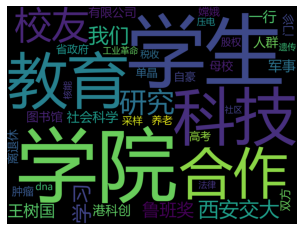

In [95]:
plt.imshow(w)
plt.axis('off')
plt.show()